# Predizione Solar Flares

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
import csv
import os

In [2]:
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

In [3]:
download("solar+flare.zip","https://archive.ics.uci.edu/static/public/89/solar+flare.zip")

In [4]:
from zipfile import ZipFile
with ZipFile("solar+flare.zip") as f:
        f.extractall()

In [5]:
columns = ["class", "LSS", "SD", "activity", "evolution", "PFA", 
            "HC", "BHC", "area", "LSA", "C-flares in 24h", 
            "M-flares in 24h", "X-flares in 24h"]
data2 = pd.read_table("flare.data2",sep=" ", names=columns, index_col=False, skiprows=1)
data1 = pd.read_table("flare.data1",sep=" ", names=columns, index_col=False, skiprows=1)

In [6]:
data = pd.concat([data1, data2], ignore_index=True)

## Obiettivo

Si vuole predirre il possibile insorgere di eruzioni solari (solar flares) analizzando le caratteristiche delle machchie solari (sun spots)

In [7]:
data

,class,LSS,SD,activity,evolution,PFA,HC,BHC,area,LSA,C-flares in 24h,M-flares in 24h,X-flares in 24h
0,C,S,O,1,2,1,1,2,1,2,0,0,0
1,D,S,O,1,3,1,1,2,1,2,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,D,S,O,1,3,1,1,2,1,2,0,0,0
4,D,A,O,1,3,1,1,2,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,H,S,X,1,2,1,1,1,1,1,0,0,0
1385,H,S,X,2,2,1,1,2,1,1,0,0,0
1386,C,S,O,1,2,1,2,2,1,1,0,0,0
1387,H,R,X,1,2,1,1,2,1,1,0,0,0


### Lista delle variabili
**Informazioni sulla classificazione provenienti da: https://www.stce.be/educational/classification**

- Class: Code for class (modified Zurich class)  (A,B,C,D,E,F,H)
    - A: unipolar group with no penumbra, representing either the formative or final stage of evolution in a sunspot group.
    - B: bipolar group without penumbra on any spots.
    - C: bipolar group with penumbra on one end of the group, in most cases surrounding the largest of the leader umbrae.
    - D: bipolar group with penumbra on spots at both ends of the group, and with length < 10°.
    - E: bipolar group with penumbra on spots at both ends of the group, and with length defined as: 10° < length < 15°.
    - F: bipolar group with penumbra on spots at both ends of the group, and length > 15 °.
    - H: unipolar group with penumbra. The principal spot is usually the leader spot remaining from a pre-existing bipolar group.
- LSS: Code for largest spot size (X,R,S,A,H,K)
    - X : no penumbra (group is class A or B).
    - R: rudimentary penumbra partially surrounds the largest spot. This penumbra is incomplete, granular rather than 
        filamentary, brighter than mature penumbra, and extends as little as 3" from the spot umbra. Rudimentary penumbra may 
        beeither in a stage of formation or dissolution.
    - S: small, symmetric. Largest spot has mature, dark, filamentary penumbra of circular or elliptical shape with some 
        irregularity along the border allowed. There is either a single umbra, or a compact cluster of umbrae, mimicking the 
        symmetry of the penumbra. The north-south diameter across the penumbra is < 2.5°.
    - A: small, asymmetric. Penumbra of the largest spot is irregular in outline and the multiple umbrae within it are 
        separated, not mimicking the symmetry of the penumbra. The north-south diameter of the penumbra is < 2.5°.
    - H: large, symmetric. Same structure as type 'S', but the north-south diameter of the penumbra > 2.5°. Therefore, the area
        must be > 250 millionths of a solar hemisphere.
    - K: large, asymmetric. Same structure as type '', but the north-south diameter > 2.5°, and so the area > 250 millionths of 
        a solar hemisphere.
- SD: Code for spot distribution (X,O,I,C)
    - X: undefined for unipolar groups (class A and H).
    - O: open. Few, if any, spots between leader and follower. Interior spots are of very small size.
    - I: intermediate. Numerous spots lie between the leading and following portions of the group, but none of them possesses a 
        mature penumbra.
    - C: compact. The area between the leading and following ends of the spot group is populated with many strong spots, with at 
        least one interior spot possessing mature penumbra. The extreme case of compact distribution has the entire spot group 
        enveloped in one continuous penumbral area.
- Activity: (1 = reduced, 2 = unchanged)
- Evolution: (1 = decay, 2 = no growth, 3 = growth)
- PFA: Previous 24 hour flare activity code (1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)
- HC: Historically-complex                    (1 = Yes, 2 = No)
- BHC: Did region become historically complex  on this pass across the sun's disk (1 = yes, 2 = no) 
- Area                                    (1 = small, 2 = large)
- LSA: Area of the largest spot                (1 = <=5, 2 = >5)

Si vogliono predirre le tre classi di flare che possono essere generate

- C-class flares production by this region in the following 24 hours (common flares);
- M-class flares production by this region in the following 24 hours (moderate flares);  
- X-class flares production by this region in the following 24 hours (severe flares);

Seleziono le variabili categoriche e binarie per sottoporle ad enconding

In [8]:
categorical = data[["class", "LSS", "SD", "evolution", "PFA","activity", "HC", "BHC", "area", "LSA"]]
#binary = data[["activity", "HC", "BHC", "area", "LSA"]]

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

In [10]:
encoded_cat = pd.DataFrame(
    encoder.fit_transform(categorical),
    columns=encoder.get_feature_names_out()
)
encoded_cat

,class_B,class_C,class_D,class_E,class_F,class_H,LSS_A,LSS_H,LSS_K,LSS_R,...,activity_1,activity_2,HC_1,HC_2,BHC_1,BHC_2,area_1,area_2,LSA_1,LSA_2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1385,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1387,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Separo i dati delle macchie solari che hanno prodotto flare da quelle inattive per osservarne le differenze.
Le variabili categoriche letterali non saranno mostrate, ma si possono effettuare osservazioni sulle restanti variablili
trattandosi di valori numerici discreti.

In [11]:
flared = data.loc[(data['C-flares in 24h']>0) | (data['M-flares in 24h']>0) | (data['X-flares in 24h']>0)]
not_flared = data.loc[(data['C-flares in 24h'] + data['M-flares in 24h'] + data['X-flares in 24h'])==0]

In [12]:
not_flared.describe()

,activity,evolution,PFA,HC,BHC,area,LSA,C-flares in 24h,M-flares in 24h,X-flares in 24h
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.0,1130.0,1130.0
mean,1.107965,2.398230,1.064602,1.353097,1.875221,1.010619,1.170796,0.0,0.0,0.0
std,0.310473,0.627673,0.342300,0.478144,0.330614,0.102548,0.376498,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.0,0.0,0.0
50%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.0,0.0,0.0
75%,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.0,0.0,0.0
max,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0


In [13]:
flared.describe()

,activity,evolution,PFA,HC,BHC,area,LSA,C-flares in 24h,M-flares in 24h,X-flares in 24h
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,1.335907,2.521236,1.200772,1.583012,1.965251,1.092664,1.196911,1.401544,0.362934,0.050193
std,0.473221,0.559045,0.589178,0.494016,0.183498,0.290523,0.398435,1.226704,0.751959,0.235819
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,2.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,8.000000,5.000000,2.000000


Il massimo numero di flare prodotti da una singola macchia nell'arco di 24 ore è di 8 per il tipo C, 5 per il tipo M e 2 per il tipo X

In [14]:
flared.loc[(flared["C-flares in 24h"]==8) | (flared["M-flares in 24h"]==5) | (flared["X-flares in 24h"]==2)]

,class,LSS,SD,activity,evolution,PFA,HC,BHC,area,LSA,C-flares in 24h,M-flares in 24h,X-flares in 24h
366,E,A,I,2,2,1,1,2,1,1,8,0,0
1283,D,K,C,2,3,1,2,2,2,1,1,3,2
1294,E,K,C,2,3,3,2,2,2,1,0,5,1


Si può inoltre notare che complessivamente, nel caso delle macchie che hanno prodotto flare, le medie delle variabili si avvicinano a valori che descrivono una maggior perturbazione della macchia rispetto alle macchie che non ne hanno prodotti.


In [15]:
Flared_in_24h = pd.Series(data.index.values).isin(pd.Series(flared.index.values)).astype(int)

Aggiungo nei dati una colonna che mi indichi se la macchia ha prodotto flare nelle ultime 24h per semplificare la produzione di grafici. Questo sarà anche il valore target da predirre.

In [16]:
try:
    data.insert(10, "flared in 24h", Flared_in_24h.values)
except:
    print(f"colonna già presente")

In [17]:
data.iloc[19:35, :]

,class,LSS,SD,activity,evolution,PFA,HC,BHC,area,LSA,flared in 24h,C-flares in 24h,M-flares in 24h,X-flares in 24h
19,C,A,I,1,2,1,1,2,1,2,0,0,0,0
20,C,S,O,1,2,1,1,2,1,1,0,0,0,0
21,B,X,O,1,3,1,1,2,1,1,0,0,0,0
22,F,K,I,1,3,1,2,2,1,2,0,0,0,0
23,B,X,O,1,2,1,1,2,1,1,0,0,0,0
24,H,R,X,1,2,1,1,1,1,2,0,0,0,0
25,B,X,I,1,3,1,1,2,1,1,0,0,0,0
26,C,R,I,1,3,1,1,2,1,2,0,0,0,0
27,B,X,O,1,3,1,1,2,1,1,0,0,0,0
28,B,X,O,1,3,1,1,2,1,2,0,0,0,0


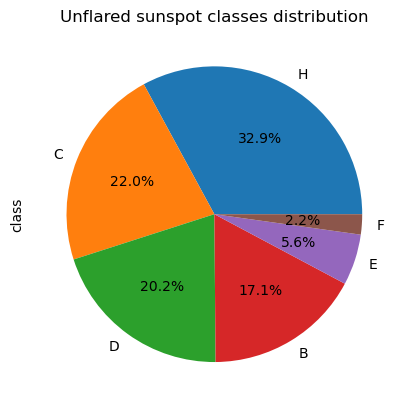

In [18]:
not_flared["class"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Unflared sunspot classes distribution")
plt.show()

Nelle osservazioni non sono presenti macchie di classe A, assenza dovuta ad una natura effimera e transitoria. Infatti la classe A rappresenta gli stadi iniziali o finali dell'evoluzione di un gruppo di macchie solari.

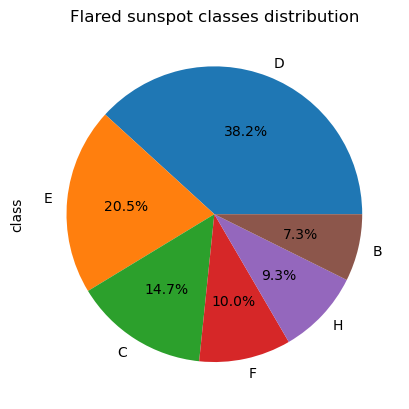

In [19]:
flared["class"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Flared sunspot classes distribution")
plt.show()

I gruppi di macchie nella loro fase di crescita sono i più attivi. Le classi E ed F nonostante rappresentino una piccola percentuale del totale, sono sensibilmente più presenti nel gruppo di macchie solari che hanno prodotto flare.

In [20]:
data["flared in 24h"].value_counts(1)

0    0.813535
1    0.186465
Name: flared in 24h, dtype: float64

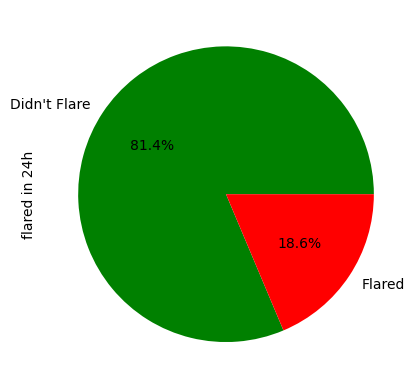

In [21]:
data["flared in 24h"].value_counts().plot.pie(colors=['g','r'],labels=["Didn't Flare",'Flared'],autopct='%1.1f%%')
plt.show()

In [22]:
pie_values = [flared["C-flares in 24h"].apply(lambda x:x!=0).sum(),
             flared["M-flares in 24h"].apply(lambda x:x!=0).sum(),
             flared["X-flares in 24h"].apply(lambda x:x!=0).sum()]
pie_labels = "C-flares", "M-flares", "X-flares"

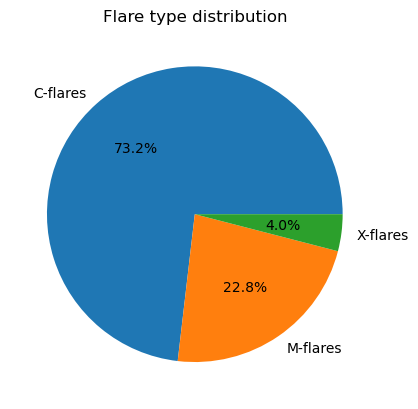

In [23]:
plt.pie(pie_values, labels=pie_labels,autopct='%1.1f%%')
plt.title("Flare type distribution")
plt.show()

## Classificazione

Proviamo a classificare le macchie che possono dare luogo ad un flare usando i metodi di classificazione DecisionTreeClassifier e LogisticRegression

In [24]:
y = data["flared in 24h"]
X = encoded_cat

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [26]:
X_val.shape

(463, 32)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

In [28]:
model_tree = DecisionTreeClassifier(max_depth=3)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

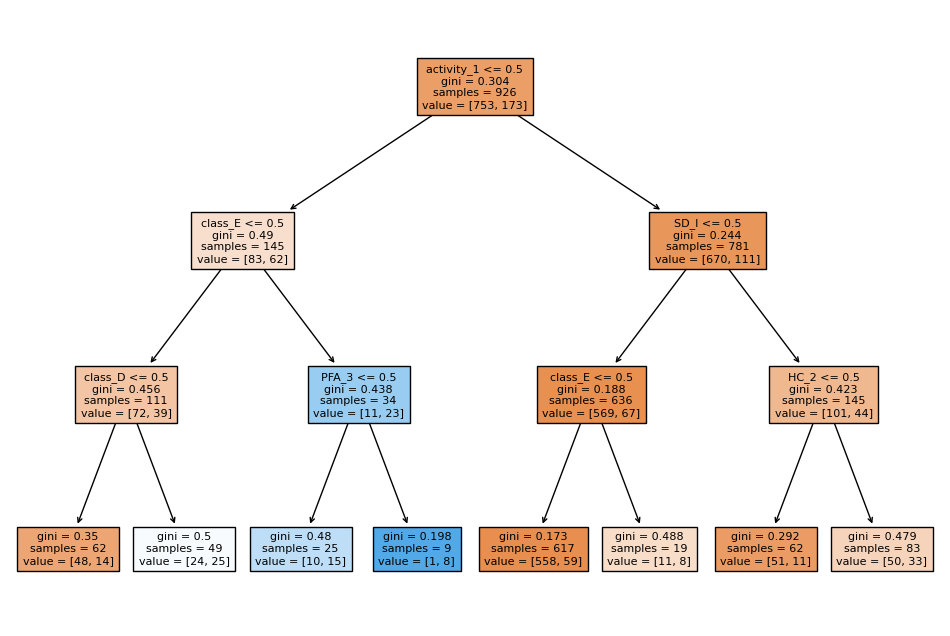

In [29]:
plt.figure(figsize=(12, 8))
plot_tree(model_tree, feature_names=X_train.columns.to_list(), max_depth=3, filled=True, fontsize=8);

In [30]:
model_tree.score(X_val, y_val)

0.7883369330453563

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)

LogisticRegression()

In [33]:
model_lr.score(X_val,y_val)

0.8056155507559395

In [34]:
pd.Series(model_lr.coef_[0],index=model_lr.feature_names_in_)

class_B       -0.553827
class_C       -0.463129
class_D        0.395344
class_E        1.029233
class_F        0.214264
class_H       -0.622439
LSS_A         -0.148151
LSS_H          0.324172
LSS_K          0.557512
LSS_R         -0.512360
LSS_S          0.089298
LSS_X         -0.311026
SD_C           0.157590
SD_I           0.490775
SD_O          -0.026480
SD_X          -0.622439
evolution_1   -0.332816
evolution_2    0.092007
evolution_3    0.240254
PFA_1         -0.022451
PFA_2         -0.135991
PFA_3          0.157888
activity_1    -0.360618
activity_2     0.360063
HC_1           0.016890
HC_2          -0.017444
BHC_1          0.048715
BHC_2         -0.049269
area_1         0.071883
area_2        -0.072437
LSA_1          0.088411
LSA_2         -0.088965
dtype: float64

Le classi evidenziate in precedenza si ripropongono nella distribuzione dei pesi. D, E ed F sono classi comuni tra le macchie che hanno prodotto flare.

Osserviamo anche il Parametro Largest Spot Size, LSS

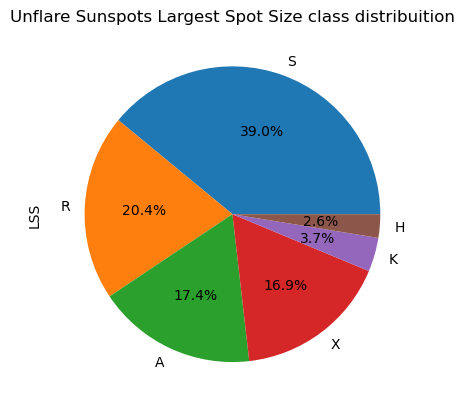

In [36]:
not_flared["LSS"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Unflare Sunspots Largest Spot Size class distribuition")
plt.show()

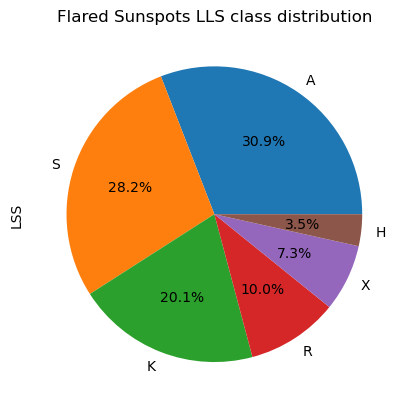

In [37]:
flared["LSS"].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Flared Sunspots LLS class distribution")
plt.show()

Anche nel dato LSS si ritrovano caratteristiche simili a quanto visto per la classe. Trovo però non corretta l'assegnazione di un peso negativo ad LSS_A in quanto ha una presenza notevolmente maggiore nelle macchie solari che hanno emesso flare rispetto a quelle "inattive".

Proviamo quindi a migliorare i modelli con una selezione degli iperparametri, un trainig ed una validazione più approfondite.

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
from sklearn.model_selection import KFold, StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)

In [40]:
for train, val in skf.split(X_train, y_train):
    print(y_train.iloc[val].value_counts())

0    251
1     58
Name: flared in 24h, dtype: int64
0    251
1     58
Name: flared in 24h, dtype: int64
0    251
1     57
Name: flared in 24h, dtype: int64


In [41]:
model = Pipeline([
    ("scaler", None),
    ("lr" ,LogisticRegression(solver="saga",max_iter=5000))
])

In [42]:
grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": [None]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 2, 5)
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 2, 5),
        "lr__l1_ratio": [0.2, 0.5]
    }
]

In [43]:
%%time
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X, y)

CPU times: total: 1min
Wall time: 1min 22s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('lr',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             param_grid=[{'lr__penalty': [None],
                          'scaler': [None, StandardScaler()]},
                         {'lr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'lr__penalty': ['l2', 'l1'],
                          'scaler': [None, StandardScaler()]},
                         {'lr__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'lr__l1_ratio': [0.2, 0.5],
                          'lr__penalty': ['elasticnet'],
                          'scaler': [None, StandardScaler()]}])

In [44]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.030301,0.001352,0.000000,0.000000,l2,StandardScaler(),0.01,NaN,"{'lr__C': 0.01, 'lr__penalty': 'l2', 'scaler':...",0.831533,0.822894,0.809935,0.821454,0.008876,1
29,0.100585,0.020751,0.005202,0.007357,elasticnet,StandardScaler(),0.1,0.5,"{'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penal...",0.831533,0.820734,0.812095,0.821454,0.007952,1
6,0.033344,0.002848,0.003212,0.004542,l2,None,0.1,NaN,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",0.829374,0.820734,0.807775,0.819294,0.008876,3
26,0.033441,0.010899,0.000000,0.000000,elasticnet,None,0.1,0.2,"{'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penal...",0.829374,0.814255,0.812095,0.818575,0.007687,4
9,0.057480,0.014698,0.000000,0.000000,l1,StandardScaler(),0.1,NaN,"{'lr__C': 0.1, 'lr__penalty': 'l1', 'scaler': ...",0.831533,0.814255,0.809935,0.818575,0.009332,4
12,0.052283,0.005367,0.000000,0.000000,l1,None,1.0,NaN,"{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...",0.831533,0.812095,0.812095,0.818575,0.009163,4
32,0.193710,0.019170,0.005585,0.007898,elasticnet,None,1.0,0.5,"{'lr__C': 1.0, 'lr__l1_ratio': 0.5, 'lr__penal...",0.829374,0.812095,0.809935,0.817135,0.008699,7
27,0.094288,0.012900,0.005207,0.007364,elasticnet,StandardScaler(),0.1,0.2,"{'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penal...",0.827214,0.812095,0.809935,0.816415,0.007687,8
30,0.173505,0.011408,0.004372,0.006183,elasticnet,None,1.0,0.2,"{'lr__C': 1.0, 'lr__l1_ratio': 0.2, 'lr__penal...",0.827214,0.812095,0.807775,0.815695,0.008334,9
28,0.038671,0.006685,0.007260,0.005331,elasticnet,None,0.1,0.5,"{'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penal...",0.812095,0.816415,0.816415,0.814975,0.002036,10


In [45]:
model = gs.best_estimator_
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.01, max_iter=5000, solver='saga'))])

In [46]:
model_weights = pd.Series(model.named_steps["lr"].coef_[0], index=X.columns)
model_weights

class_B       -0.090002
class_C       -0.061659
class_D        0.140399
class_E        0.156694
class_F        0.116983
class_H       -0.149702
LSS_A          0.052227
LSS_H          0.021089
LSS_K          0.157490
LSS_R         -0.105822
LSS_S          0.014690
LSS_X         -0.083548
SD_C           0.078426
SD_I           0.139739
SD_O          -0.011842
SD_X          -0.149702
evolution_1   -0.068591
evolution_2   -0.014257
evolution_3    0.048800
PFA_1         -0.006747
PFA_2         -0.016224
PFA_3          0.015395
activity_1    -0.096957
activity_2     0.096957
HC_1          -0.028508
HC_2           0.028508
BHC_1         -0.039623
BHC_2          0.039623
area_1        -0.030920
area_2         0.030920
LSA_1          0.021831
LSA_2         -0.021831
dtype: float64

In [47]:
pd.DataFrame(data={"Model_con_gs":model.named_steps["lr"].coef_[0],"Model_no_gs":model_lr.coef_[0]},index=X.columns)

,Model_con_gs,Model_no_gs
class_B,-0.090002,-0.553827
class_C,-0.061659,-0.463129
class_D,0.140399,0.395344
class_E,0.156694,1.029233
class_F,0.116983,0.214264
class_H,-0.149702,-0.622439
LSS_A,0.052227,-0.148151
LSS_H,0.021089,0.324172
LSS_K,0.157490,0.557512
LSS_R,-0.105822,-0.512360


Osservando le differenze con i pesi del modello precedente si nota un peso positivo assegnato a LSS_A, mostrando fondati i dubbi che ho avuto in precedenza.

Effettuiamo una grid search anche su DecisionTreeClassifier per migliorarne l'accuratezza

In [48]:
model_tree = Pipeline([
    ("classifier", DecisionTreeClassifier(random_state=42))
])

In [49]:
grid_tree = [{
    "classifier__criterion":["gini", "entropy", "log_loss"],
    "classifier__splitter":["best", "random"],
    "classifier__max_depth":range(1,11),
    "classifier__max_features":range(1,32)
    },
    {
    "classifier__criterion":["gini", "entropy", "log_loss"],
    "classifier__splitter":["best", "random"],
    "classifier__max_depth":range(1,11),
    "classifier__max_features":np.linspace(0.001,1,22)
    },
    {
    "classifier__criterion":["gini", "entropy", "log_loss"],
    "classifier__splitter":["best", "random"],
    "classifier__max_depth":range(1,11),
    "classifier__max_features":["log2", "sqrt", None]
    }
]

In [50]:
%%time
gs_tree = GridSearchCV(model_tree, grid_tree, cv=skf)
gs_tree.fit(X,y)

CPU times: total: 1min 32s
Wall time: 1min 56s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy',
                                                    'log_loss'],
                          'classifier__max_depth': range(1, 11),
                          'classifier__max_features': range(1, 32),
                          'classifier__splitter': ['best', 'random']},
                         {'classifi...
       0.23885714, 0.28642857, 0.334     , 0.38157143, 0.42914286,
       0.47671429, 0.52428571, 0.57185714, 0.61942857, 0.667     ,
       0.71457143, 0.76214286, 0.80971429, 0.85728571, 0.90485714,
       0.95242857, 1.        ]),
                          'classifier__splitter': ['best', 'random']},
                         {'classifier__criterion': ['gini', 'entropy',
                                                    'log_loss'],
                          'classifier__max_depth': range(1, 11),
                          'classifier__max_features': ['log2', 'sqrt', None],
                          'classifier__splitter': ['best', 'random']}])

In [51]:
pd.DataFrame(gs_tree.cv_results_).sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
873,0.005250,0.007425,0.000000,0.000000,entropy,5,3,random,"{'classifier__criterion': 'entropy', 'classifi...",0.829374,0.827214,0.822894,0.826494,0.002694,1
1493,0.005199,0.007352,0.005217,0.007378,log_loss,5,3,random,"{'classifier__criterion': 'log_loss', 'classif...",0.829374,0.827214,0.822894,0.826494,0.002694,1
2481,0.006406,0.009059,0.004209,0.005952,entropy,5,0.096143,random,"{'classifier__criterion': 'entropy', 'classifi...",0.829374,0.827214,0.822894,0.826494,0.002694,1
2921,0.008245,0.006402,0.002214,0.003131,log_loss,5,0.096143,random,"{'classifier__criterion': 'log_loss', 'classif...",0.829374,0.827214,0.822894,0.826494,0.002694,1
2041,0.005209,0.007367,0.002872,0.004061,gini,5,0.096143,random,"{'classifier__criterion': 'gini', 'classifier_...",0.829374,0.827214,0.822894,0.826494,0.002694,1
253,0.008422,0.006458,0.000000,0.000000,gini,5,3,random,"{'classifier__criterion': 'gini', 'classifier_...",0.829374,0.827214,0.822894,0.826494,0.002694,1
1909,0.005205,0.007360,0.005217,0.007377,gini,2,0.096143,random,"{'classifier__criterion': 'gini', 'classifier_...",0.825054,0.827214,0.820734,0.824334,0.002694,7
1307,0.010459,0.007396,0.005206,0.007362,log_loss,2,3,random,"{'classifier__criterion': 'log_loss', 'classif...",0.825054,0.827214,0.820734,0.824334,0.002694,7
687,0.000808,0.001143,0.005261,0.007440,entropy,2,3,random,"{'classifier__criterion': 'entropy', 'classifi...",0.825054,0.827214,0.820734,0.824334,0.002694,7
2349,0.005205,0.007361,0.005212,0.007371,entropy,2,0.096143,random,"{'classifier__criterion': 'entropy', 'classifi...",0.825054,0.827214,0.820734,0.824334,0.002694,7


In [52]:
model_tree = gs_tree.best_estimator_
model_tree

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=5, max_features=3,
                                        random_state=42, splitter='random'))])

In [53]:
model_tree.get_params()

{'memory': None,
 'steps': [('classifier',
   DecisionTreeClassifier(max_depth=5, max_features=3, random_state=42,
                          splitter='random'))],
 'verbose': False,
 'classifier': DecisionTreeClassifier(max_depth=5, max_features=3, random_state=42,
                        splitter='random'),
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5,
 'classifier__max_features': 3,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__random_state': 42,
 'classifier__splitter': 'random'}

In [54]:
model_tree["classifier"]

DecisionTreeClassifier(max_depth=5, max_features=3, random_state=42,
                       splitter='random')

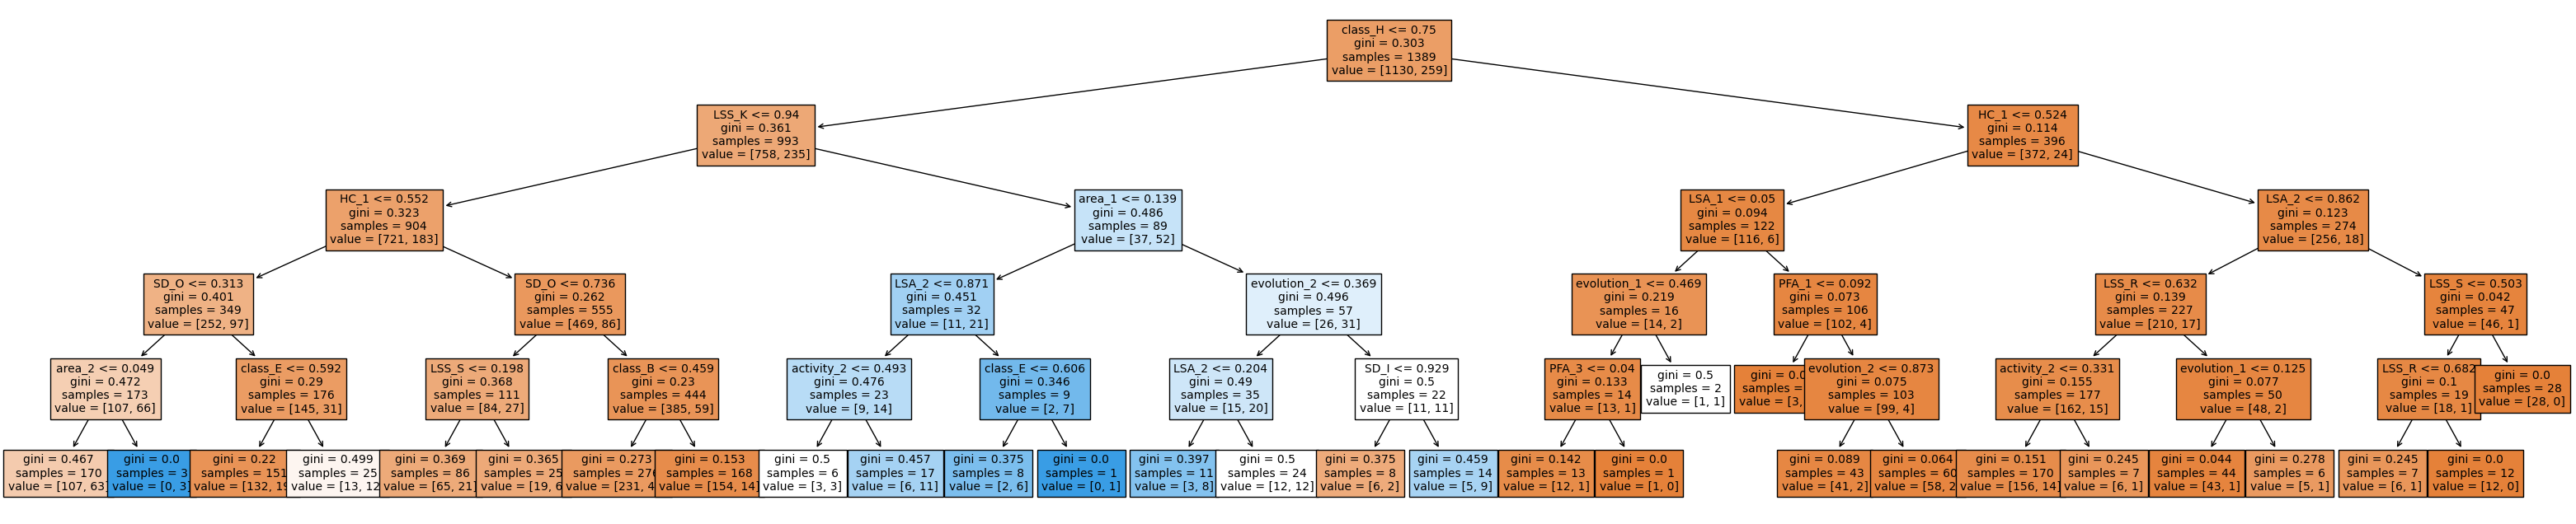

In [55]:
plt.figure(figsize=(40, 8))
plot_tree(model_tree["classifier"], feature_names=X_train.columns.to_list(), max_depth=6, filled=True, fontsize=10);

DecisionTreeClassifier ha beneficiato maggiormente dalla grid search risultando alla fine risultando leggermente più accurato rispetto alla LogisticRegression.